# Alphalens Analisis

In [3]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import factset, USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Returns, SimpleMovingAverage, CustomFactor, RSI

from alphalens.performance import mean_information_coefficient
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_information_tear_sheet, create_returns_tear_sheet
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data import Fundamentals

from quantopian.pipeline.data.factset import Fundamentals as fFundamentals
# Constraint Parameters

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:11: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  # This is added back by InteractiveShellApp.init_path()
/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:12: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  if sys.path[0] == '':


## Define Your Alpha Factor Here

Spend your time in this cell, creating good factors. Then simply run the rest of the notebook to analyze `factor_to_analyze`!

In [5]:
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

# Here we define the maximum position size that can be held for any
# given stock. If you have a different idea of what these maximum
# sizes should be, feel free to change them. Keep in mind that the
# optimizer needs some leeway in order to operate. Namely, if your
# maximum is too small, the optimizer may be overly-constrained.
MAX_SHORT_POSITION_SIZE = 1.0 / TOTAL_POSITIONS
MAX_LONG_POSITION_SIZE = 1.0 / TOTAL_POSITIONS
def make_pipeline():
    """
    A function that creates and returns our pipeline.

    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation. In particular, this function can be
    copy/pasted into research and run by itself.

    Returns
    -------
    pipe : Pipeline
        Represents computation we would like to perform on the assets that make
        it through the pipeline screen.
    """
    # The factors we create here are based on fundamentals data and a moving
    # average of sentiment data
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )
    ebitda = Fundamentals.ebitda
    admin_expense = Fundamentals.administrative_expense
    short_liabi = fFundamentals.liabs_curr
    coverRatio = ebitda.latest/(admin_expense.latest + short_liabi.latest) 
    
    dif_twitter = aggregated_twitter_withretweets_stocktwits.bull_minus_bear
    totalmessages = aggregated_twitter_withretweets_stocktwits.total_scanned_messages
    ratio = dif_twitter.latest/totalmessages.latest
    universe = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    coverRatio_winsorized = coverRatio.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    ratio_winsorized = ratio.winsorize(min_percentile=0.05, max_percentile=0.95)
    goodw = fFundamentals.gw_impair_qf.latest
    goodw_winsorized = goodw.winsorize(min_percentile=0.05, max_percentile=0.95)
    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    combined_factor = (
        value_winsorized.zscore() +
        quality_winsorized.zscore() +
        sentiment_score_winsorized.zscore() +
        coverRatio_winsorized.zscore() +
        ratio_winsorized +
        goodw_winsorized
    )

    # Build Filters representing the top and bottom baskets of stocks by our
    # combined ranking system. We'll use these as our tradeable universe each
    # day.
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    # The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

factor_data = run_pipeline(make_pipeline(), '2017-5-1', '2019-5-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2017-5-1', '2019-5-1', fields='open_price')

## Determine The Decay Rate Of Your Alpha Factor.

Dropped 15.2% entries from factor data: 15.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


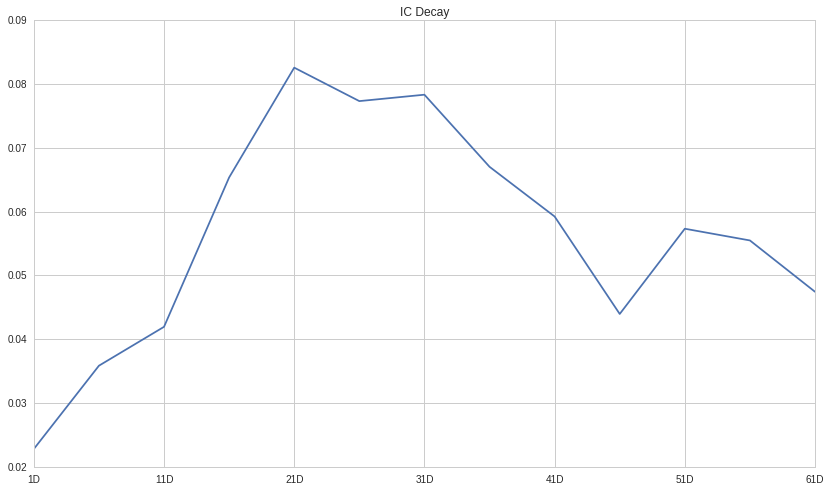

In [7]:
longest_look_forward_period = 63 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['combined_factor'],
    prices = pricing_data,
    periods = range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")

## Create Group Neutral Tear Sheets

Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.024,0.035,0.036
IC Std.,0.305,0.307,0.280
Risk-Adjusted IC,0.080,0.115,0.129
t-stat(IC),1.779,2.559,2.864
p-value(IC),0.076,0.011,0.004
IC Skew,-0.110,0.199,-0.090
IC Kurtosis,-0.153,-0.269,-0.261


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


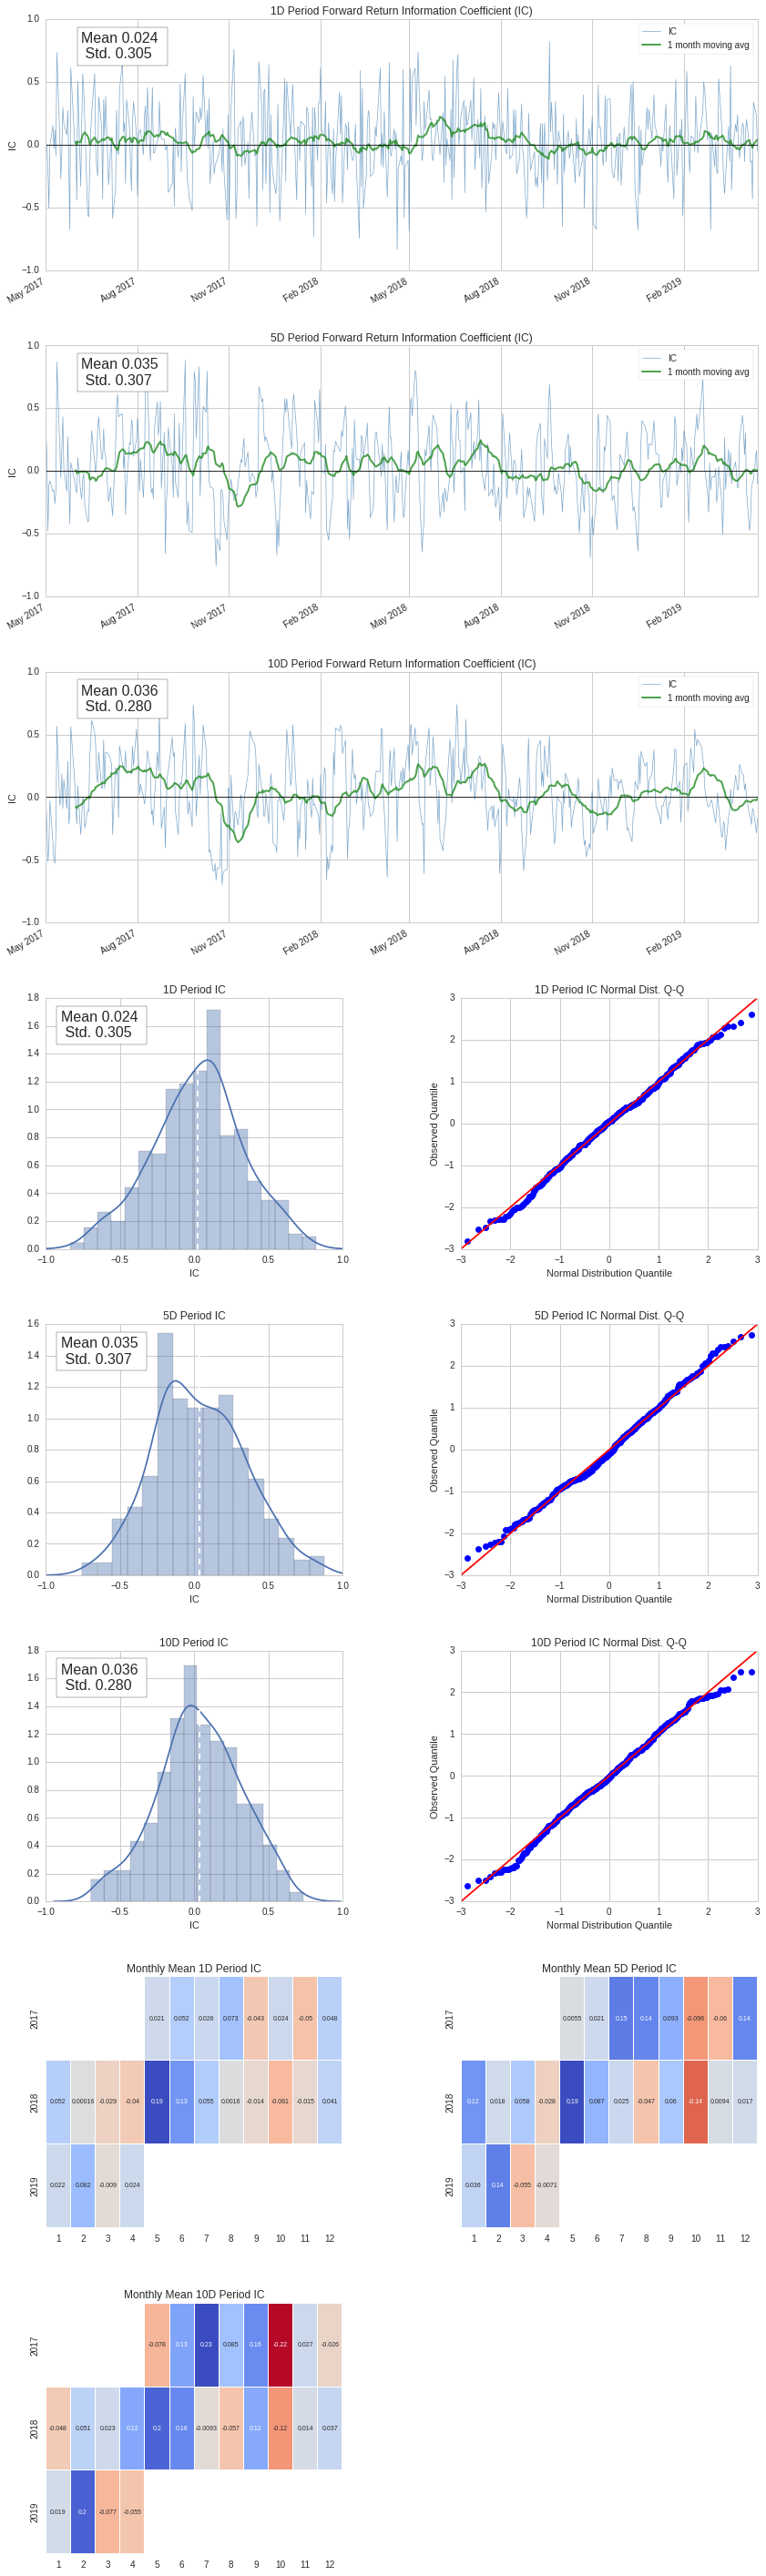

Returns Analysis


,1D,5D,10D
Ann. alpha,0.027,0.039,0.048
beta,0.090,0.124,0.146
Mean Period Wise Return Top Quantile (bps),-3.883,0.671,0.532
Mean Period Wise Return Bottom Quantile (bps),-1.510,-0.681,-1.139
Mean Period Wise Spread (bps),-2.373,1.050,1.335


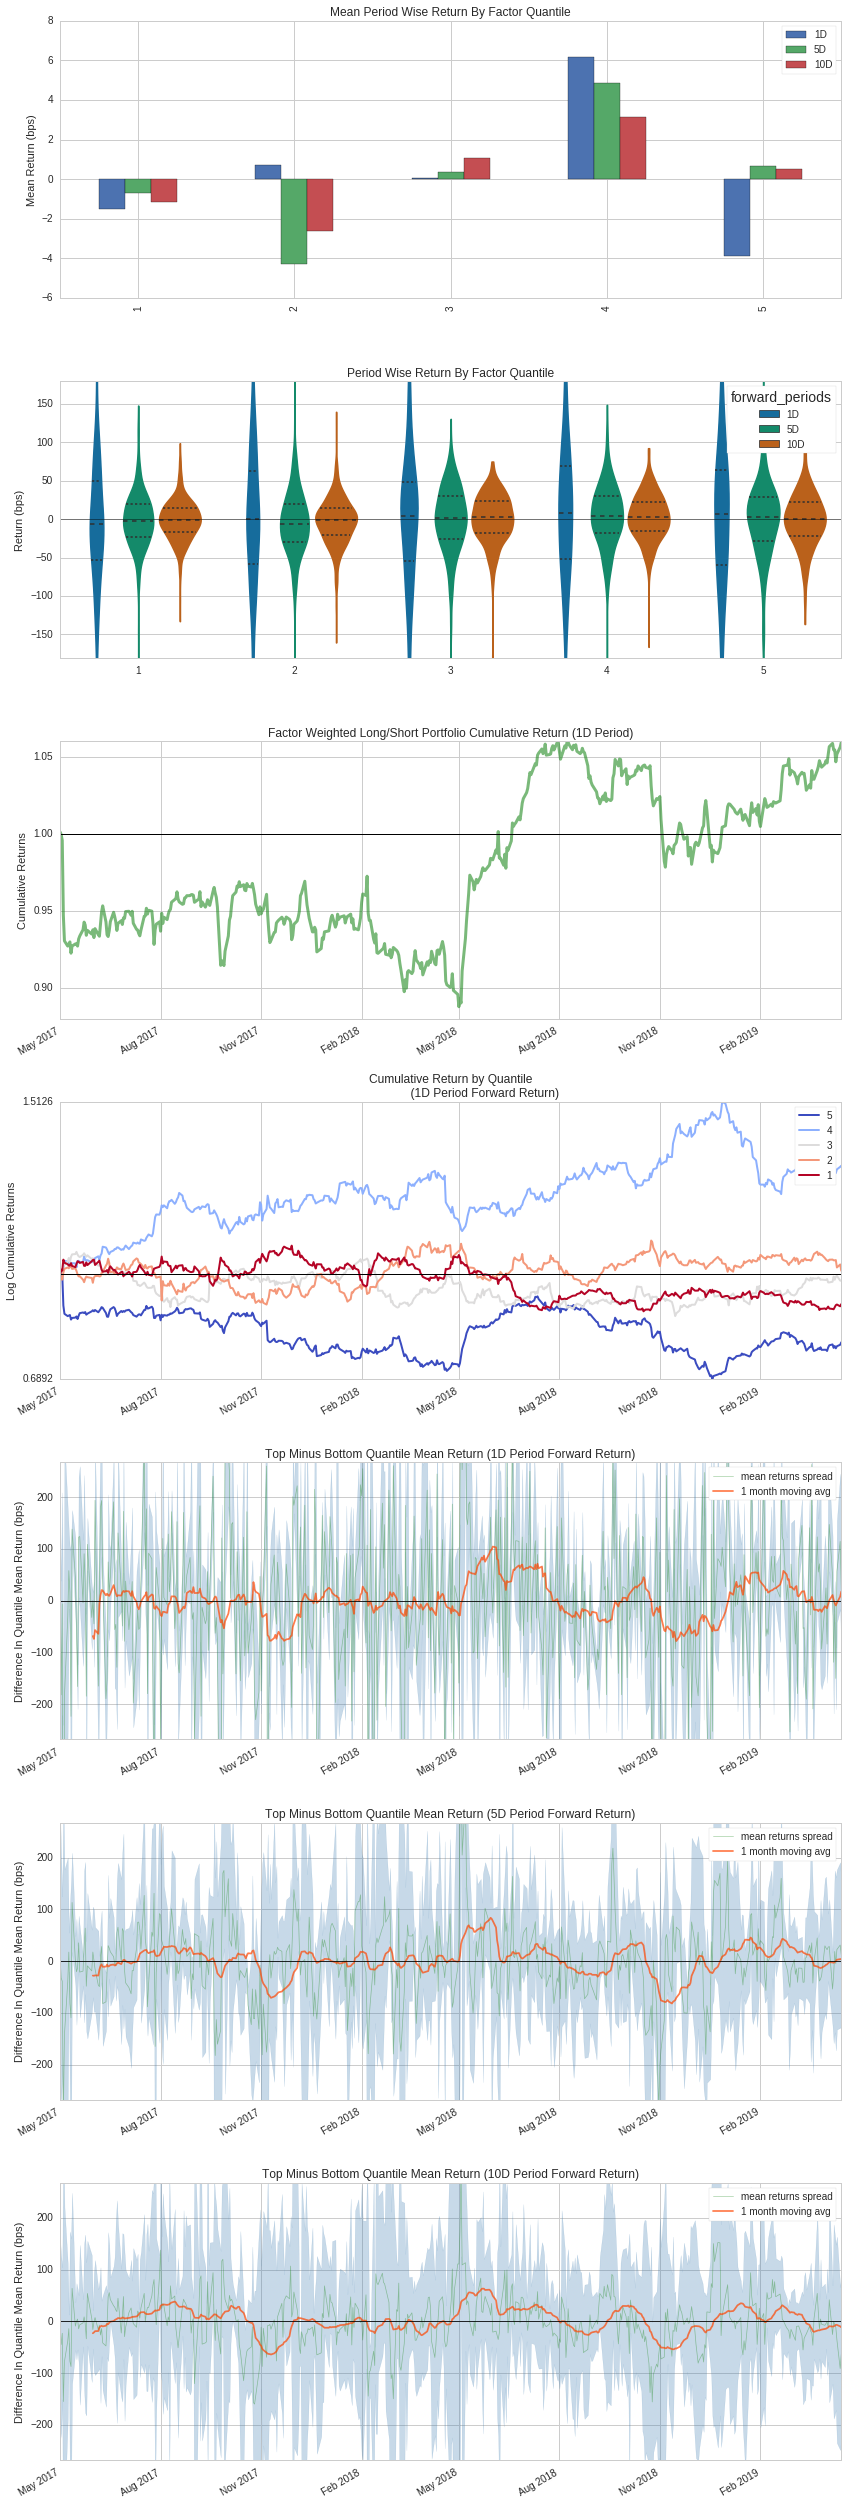

In [23]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['combined_factor'],
    prices = pricing_data,
    periods = (1,5,10)
)

create_information_tear_sheet(merged_data)
create_returns_tear_sheet(merged_data)